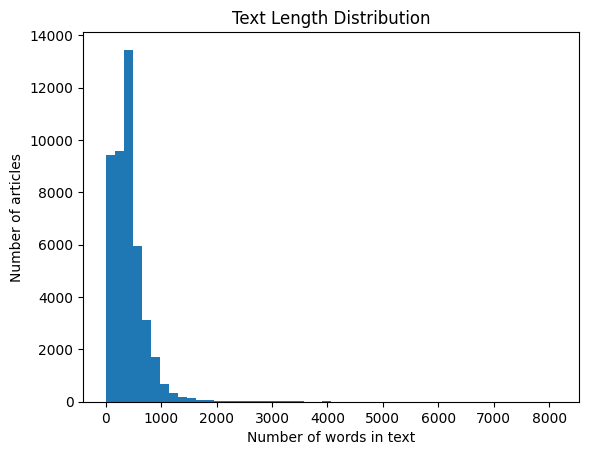

Total number of news: 44898


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

true_df['label'] = 1
fake_df['label'] = 0

df = pd.concat([true_df, fake_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.to_csv('News.csv', index=False)

df['text_length'] = df['text'].astype(str).apply(lambda x: len(x.split()))

plt.hist(df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Number of words in text')
plt.ylabel('Number of articles')
plt.show()

print('Total number of news:', len(df))



c:\Users\15173\.conda\envs\fake_news_bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors


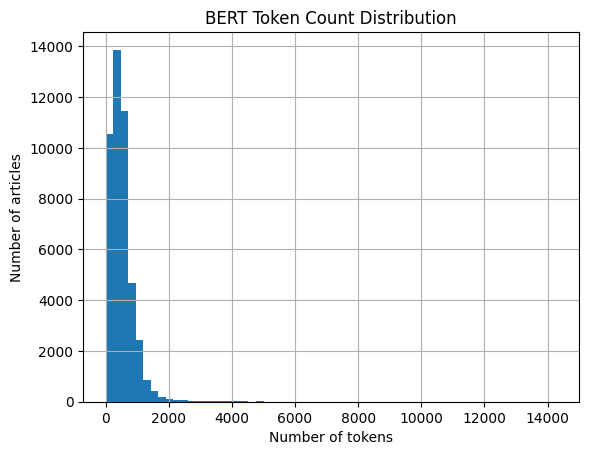

Max token length: 14285
Min token length: 2
Average token length: 510.61715443895054


In [2]:
from transformers import BertTokenizer


df = pd.read_csv('News.csv')
texts = df['text'].astype(str).tolist()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded = tokenizer(texts, padding=False, truncation=False, return_tensors='np')

lengths = [len(tokens) for tokens in encoded['input_ids']]

plt.hist(lengths, bins=60)
plt.title('BERT Token Count Distribution')
plt.xlabel('Number of tokens')
plt.ylabel('Number of articles')
plt.grid(True)
plt.show()

print('Max token length:', max(lengths))
print('Min token length:', min(lengths))
print('Average token length:', sum(lengths) / len(lengths))


In [3]:

import torch
from sklearn.model_selection import train_test_split


class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

df = pd.read_csv('News.csv')
texts = df['text'].astype(str).tolist()
labels = df['label'].tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 512

train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_len)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer, max_len)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15173\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Cleaning texts: 100%|██████████| 23481/23481 [00:00<00:00, 23971.29it/s]


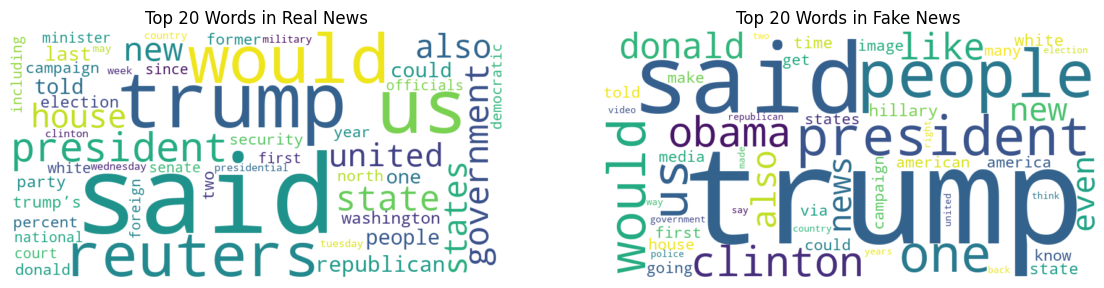

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import string
from nltk.corpus import stopwords
from collections import Counter
from tqdm import tqdm
import nltk

nltk.download('stopwords')

df = pd.read_csv('News.csv')

stop_words = set(stopwords.words('english'))


def clean_tokens(texts):
    all_tokens = []
    for text in tqdm(texts, desc="Cleaning texts"):
        text = str(text).lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        all_tokens.extend(tokens)
    return all_tokens


real_texts = df[df['label'] == 1]['text'].tolist()
fake_texts = df[df['label'] == 0]['text'].tolist()

real_tokens = clean_tokens(real_texts)
fake_tokens = clean_tokens(fake_texts)


real_freq = dict(Counter(real_tokens).most_common(50))
fake_freq = dict(Counter(fake_tokens).most_common(50))


real_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(real_freq)
fake_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fake_freq)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 Words in Real News')

plt.subplot(1, 2, 2)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 Words in Fake News')

plt.show()


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv("News.csv").sample(frac=1, random_state=42).reset_index(drop=True)
df_small = df.iloc[:10000]
texts = df_small['text'].astype(str).tolist()
labels = df_small['label'].tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_len=512)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer, max_len=512)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds)
    }

# Define the training configuration for the DistilBERT model.
# The model will be trained for up to 5 epochs, with a batch size of 8 for both training and evaluation.
# Evaluation and checkpoint saving are performed at the end of each epoch.
# Training logs (such as loss) are recorded every 100 steps.
# After training, the model with the highest evaluation accuracy will be automatically reloaded.
# To conserve disk space, only the best model checkpoint is retained.
# All outputs, including logs and model checkpoints, are saved to the specified directories.
training_args = TrainingArguments(
    output_dir='./distilbert_output',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  #eraly stop
)

trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\15173\.conda\envs\fake_news_bert\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.039100,0.005708,0.998500,0.996936,1.000000,0.998465
2,0.014700,0.005365,0.999500,0.998976,1.000000,0.999488
3,0.000000,0.006068,0.999500,0.998976,1.000000,0.999488


TrainOutput(global_step=3000, training_loss=0.007001829185484288, metrics={'train_runtime': 9234.1706, 'train_samples_per_second': 4.332, 'train_steps_per_second': 0.541, 'total_flos': 3179217567744000.0, 'train_loss': 0.007001829185484288, 'epoch': 3.0})

              precision    recall  f1-score   support

           0     1.0000    0.9990    0.9995      1024
           1     0.9990    1.0000    0.9995       976

    accuracy                         0.9995      2000
   macro avg     0.9995    0.9995    0.9995      2000
weighted avg     0.9995    0.9995    0.9995      2000



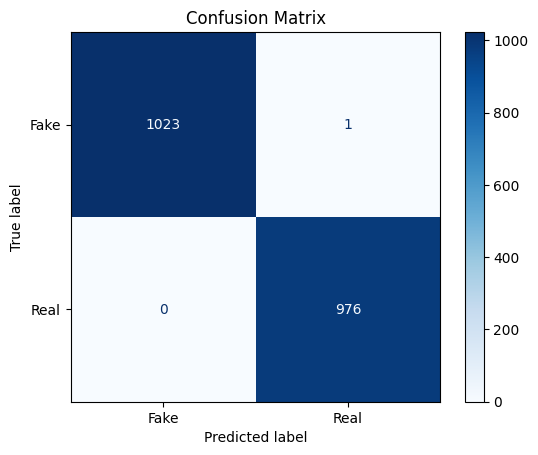

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


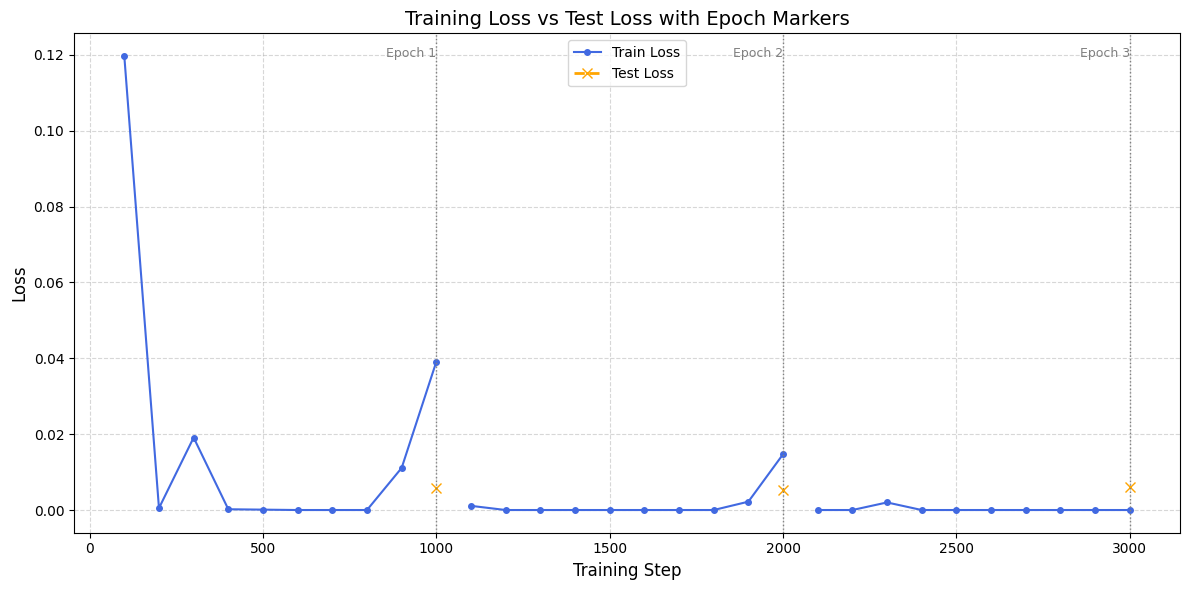

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


log_history = pd.DataFrame(trainer.state.log_history)


loss_df = log_history[
    log_history['loss'].notnull() | log_history['eval_loss'].notnull()
]


epoch_steps = loss_df[loss_df['eval_loss'].notnull()]['step'].tolist()


plt.figure(figsize=(12, 6))
if 'loss' in loss_df.columns:
    plt.plot(loss_df['step'], loss_df['loss'], label='Train Loss',
             color='royalblue', marker='o', markersize=4, linewidth=1.5)
if 'eval_loss' in loss_df.columns:
    plt.plot(loss_df['step'], loss_df['eval_loss'], label='Test Loss',
             color='orange', marker='x', markersize=7, linestyle='--', linewidth=2)


for i, step in enumerate(epoch_steps):
    plt.axvline(x=step, color='gray', linestyle=':', linewidth=1)
    plt.text(step, plt.ylim()[1]*0.95, f"Epoch {i+1}", color='gray', fontsize=9, ha='right')


plt.xlabel("Training Step", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss vs Test Loss with Epoch Markers", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


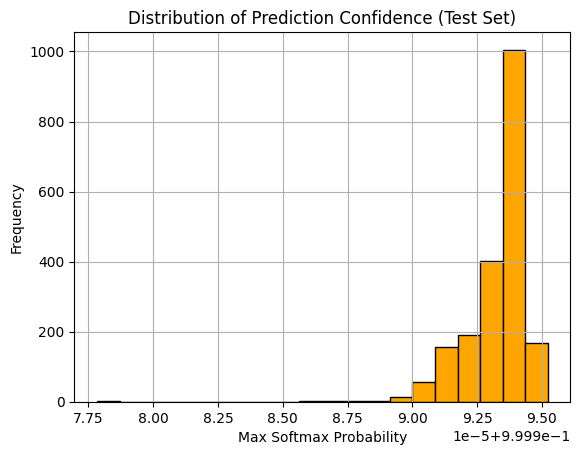

In [13]:
import torch
import numpy as np
from torch.nn.functional import softmax

outputs = trainer.predict(test_dataset).predictions
probs = softmax(torch.tensor(outputs), dim=1).numpy()
max_probs = probs.max(axis=1)


import matplotlib.pyplot as plt
plt.hist(max_probs, bins=20, color='orange', edgecolor='black')
plt.title("Distribution of Prediction Confidence (Test Set)")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import torch


texts = df_small['text'].astype(str).tolist()
labels = df_small['label'].tolist()

_, new_test_texts, _, new_test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=222 #you may change the num here 
)


class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

new_test_dataset = NewsDataset(new_test_texts, new_test_labels, tokenizer)


new_eval_results = trainer.predict(new_test_dataset)
pred_labels = new_eval_results.predictions.argmax(axis=1)


print(" Evaluation on New Test Set (random_state=123):")
print(classification_report(new_test_labels, pred_labels, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(new_test_labels, pred_labels))


 Evaluation on New Test Set (random_state=123):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1064
           1     1.0000    1.0000    1.0000       936

    accuracy                         1.0000      2000
   macro avg     1.0000    1.0000    1.0000      2000
weighted avg     1.0000    1.0000    1.0000      2000

Confusion Matrix:
[[1064    0]
 [   0  936]]


Evaluation on Perturbed Test Set (First sentence removed):
              precision    recall  f1-score   support

           0     0.6995    1.0000    0.8232      1064
           1     1.0000    0.5118    0.6770       936

    accuracy                         0.7715      2000
   macro avg     0.8498    0.7559    0.7501      2000
weighted avg     0.8402    0.7715    0.7548      2000

Accuracy on Perturbed Set: 0.7715


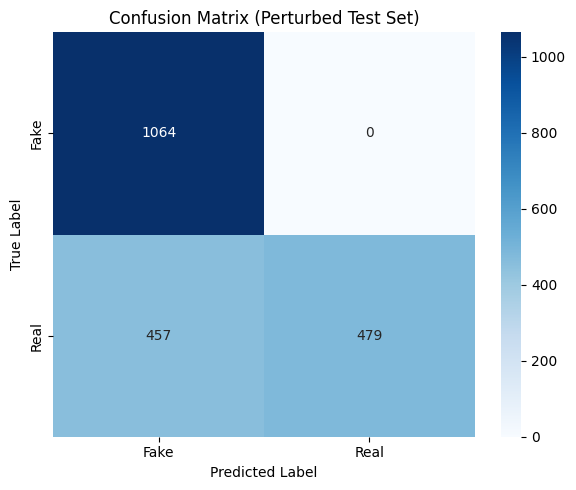

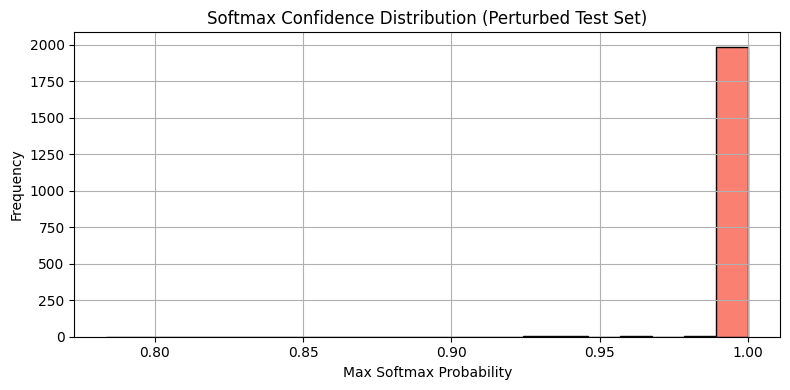

In [16]:
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torch.nn.functional import softmax

# remove the first sentence
# This simulates a mild data corruption or incompleteness
def perturb_text(text):
    parts = text.split('.')
    return '.'.join(parts[1:]).strip() if len(parts) > 1 else text

# perturbation to the test texts
perturbed_texts = [perturb_text(t) for t in new_test_texts]


perturbed_dataset = NewsDataset(perturbed_texts, new_test_labels, tokenizer)


perturbed_outputs = trainer.predict(perturbed_dataset)
perturbed_preds = perturbed_outputs.predictions.argmax(axis=1)

# Softmax confidence
probs = softmax(torch.tensor(perturbed_outputs.predictions), dim=1).numpy()
max_probs = probs.max(axis=1)


print("Evaluation on Perturbed Test Set (First sentence removed):")
print(classification_report(new_test_labels, perturbed_preds, digits=4))
print(f"Accuracy on Perturbed Set: {accuracy_score(new_test_labels, perturbed_preds):.4f}")


conf_mat = confusion_matrix(new_test_labels, perturbed_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Perturbed Test Set)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))
plt.hist(max_probs, bins=20, color='salmon', edgecolor='black')
plt.title("Softmax Confidence Distribution (Perturbed Test Set)")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()
